In [1]:


!pip install pymc3 --upgrade  # This must be called every first run
!pip install PyAstronomy

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.9.3)


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm
from PyAstronomy import pyasl

import numpy as np
import scipy
import pymc3 as pm

from google.colab import drive
drive.mount('/content/drive')



#  Ballesteros' formula, function for BV given T

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
##### OPTIONS #####

map = 0       # 1 - use find map, 0 - sample 
samples = 800  #if sampling, this is the number that decides the sampling and tuning
tune = 800

opt_params = 0   # if 1 use predetermined values

errorbars = 0   # plot error bars on surface plot 
smp_rt = 1     # every nth point of true data
num_gen =400 # given n will produce n x n points of predictions




data = np.genfromtxt('/content/drive/My Drive/data/data1.csv', delimiter=',', skip_header=1)
#!pip install pymc3 --upgrade  # This must be called every first run

Teff = data[:,0][0::smp_rt] # Teff
Prot = data[:, 1][0::smp_rt]  # Prot
Age = data[:, 2][0::smp_rt]  # Age 
Mass = data[:, 3][0::smp_rt]   # mass
b = pyasl.BallesterosBV_T()
BV =  b.bv2T(np.array(Teff))


In [4]:
'''b = pyasl.BallesterosBV_T()'''


'b = pyasl.BallesterosBV_T()'

# Age 

[10.92873499  0.53712399]


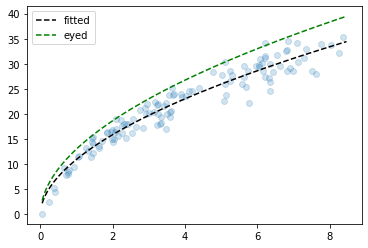

In [5]:


limit = (np.where(np.logical_and(Mass>0.9, Mass<=0.94)))

Teff_short = Teff[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]


plt.scatter(Age_short, Prot_short, alpha=0.2)



coefs = scipy.optimize.curve_fit(lambda t,a,c: a*t**c,  Age_short,  Prot_short, p0=(10,0.5))
print(coefs[0])

x = np.linspace(np.amin(Age),np.amax(Age),1000)
y1 = coefs[0][0]* x **coefs[0][1]
y2 = 13*x**0.52
plt.plot(x,y1, color='k', linestyle='--', label='fitted')
plt.plot(x,y2, color='g', linestyle='--', label='eyed')
plt.legend()



In [6]:
A = coefs[0][0]
c = coefs[0][1]
X = np.array([Age, Mass]).T 

with pm.Model() as model:

    A_ = pm.Normal('A_', A, A*0.5)
    c_ = pm.Normal('c_', c, c*0.3)
    mean = A_ * Age**c_

    l1 = pm.Lognormal('l1', mu=np.log(14.0), sigma=0.01)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(0.1), sigma=0.01)
    
    resid = Prot - mean

    sf2 = pm.Lognormal("sf2", mu=np.log(15), sigma=1)
    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=1)
    

    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2
    K = K1 * K2

    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X, y=resid, noise=1.0)

    mp = pm.find_MAP()


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


{'A_': array(7.32095523), 'c_': array(0.77471615), 'l1_log__': array(2.63895506), 'l2_log__': array(-2.46994588), 'sf2_log__': array(1.15824467), 'sf1_log__': array(1.15824468), 'l1': array(13.9985683), 'l2': array(0.08458944), 'sf2': array(3.18433882), 'sf1': array(3.18433882)}


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


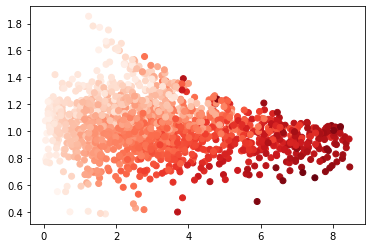

7.320955232782781 0.7747161519306495


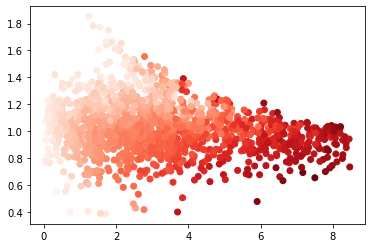

In [7]:
print(mp)
A = mp['A_']
c = mp['c_']

age_new = np.random.rand(400) * 8
mass_new = np.random.rand(400) * 1.0 + 0.4
Xnew = np.array([age_new, mass_new]).T
mu, var = gp.predict(X, point=mp, diag=True, pred_noise=True)




plt.scatter(Age, Mass, c=Prot, cmap='Reds')
plt.show()
plt.scatter(Age, Mass, c = mp['A_'] * Age**mp['c_'] + mu, cmap='Reds')

print(A, c)




[21.59579842 -0.97296007]


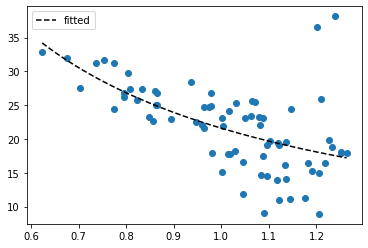

In [8]:
limit = (np.where(np.logical_and(Age>4.4, Age<=5)))

Teff_short = Teff[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]
Mass_short = Mass[limit]



plt.scatter(Mass_short, Prot_short)


coefs2 = scipy.optimize.curve_fit(lambda t,a,c: a*t**c,  Mass_short,  Prot_short)
print(coefs2[0])

x = np.linspace(np.amin(Mass_short),np.amax(Mass_short),1000)
y1 = coefs2[0][0]* x **coefs2[0][1]

plt.plot(x,y1, color='k', linestyle='--', label='fitted')
plt.legend()






{'B_': array(21.59579836), 'd_': array(-0.97295635), 'l1_log__': array(1.29240831), 'l2_log__': array(0.05941952), 'sf2_log__': array(4.92069669), 'sf1_log__': array(4.92069669), 'n_log__': array(1.08714624), 'l1': array(3.64154597), 'l2': array(1.06122035), 'sf2': array(137.09809524), 'sf1': array(137.0980948), 'n': array(2.96579831)}


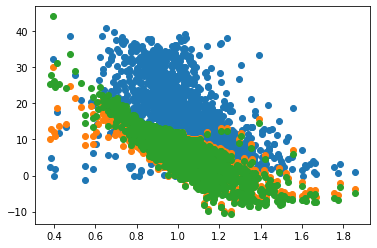

In [9]:
B = coefs2[0][0]
d = coefs2[0][1]
X = np.array([Age, Mass]).T 



with pm.Model() as model:

    B_= pm.Normal('B_', B, B*0.5)


    d_ = pm.Normal('d_', d, d)



    mean =  B_ *Mass**d_

    resid = Prot - mean



    l1 = pm.Lognormal('l1', mu=np.log(3.6), sigma=0.11)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(0.4), sigma=0.11)
  
    sf2 = pm.Lognormal("sf2", mu=np.log(160), sigma=1)
    sf1 = pm.Lognormal("sf1", mu=np.log(160), sigma=1)


    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2
    
    K = K1 * K2

    n = pm.HalfCauchy("n", beta=3)


    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X, y=resid, noise=n)
    
    mp = pm.find_MAP()
    
print(mp) 



#plt.scatter(Age, Mass, c=Prot, cmap='Reds')
plt.scatter(Mass, Prot)
plt.scatter(Mass, A* Mass**mp['d_'] + mu)
plt.scatter(Mass, A* Mass**-1.6 + mu)
plt.show()
#plt.scatter(Age, Mass, c = A * Mass**mp['d_'] + mu, cmap='Reds')

In [10]:
d = mp['d_']


A = A
c=0.52
X = np.array([Age, Mass]).T 
map = 1 #################################################################
with pm.Model() as model:

    A_ = pm.Normal('A_', A, A*0.5)


    #c_ = pm.Normal('c_', c, c*0.01)
    c_ = c



    d_ = pm.Normal('d_', d, d*0.03)


    #d_ = d
    #c_ = c
    #A_ = A
     

    mean = A_ * Age**c_   * Mass **d_


    l1 = pm.Lognormal('l1', mu=np.log(14.0), sigma=0.11)  # 1
    #l2 = pm.Lognormal('l2', mu=np.log(0.04), sigma=0.11)
    l2 = pm.Lognormal('l2', mu=np.log(3.6), sigma=0.11)
    
    resid = Prot - mean


    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=5)
    sf2 = pm.Lognormal("sf2", mu=np.log(40), sigma=15)
    


    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2

    K = K1 * K2
    
    n = pm.HalfCauchy("n", beta=3)
    n = 1

    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X, y=resid, noise=n)
    if map:
      mp = pm.find_MAP()
    else:
      mp = pm.sample(samples, tune=tune, cores=2)


In [11]:
if not map:
  with model: 
    print(pm.summary(mp).round(2))
else:
  print(mp)


A = mp['A_']
d = mp['d_']


{'A_': array(7.31490748), 'd_': array(-0.8939383), 'l1_log__': array(2.57822682), 'l2_log__': array(0.37304643), 'sf1_log__': array(2.99593818), 'sf2_log__': array(3.97676736), 'n_log__': array(1.09775696), 'l1': array(13.17375793), 'l2': array(1.45215177), 'sf1': array(20.00411851), 'sf2': array(53.3443125), 'n': array(2.99743511)}


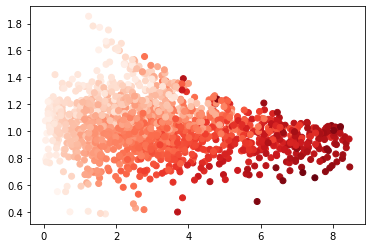

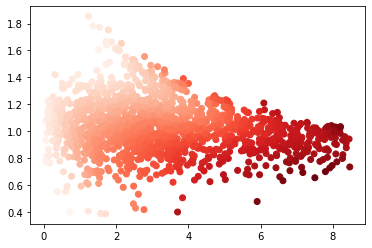

In [12]:

## try and predict outside of age range. 

#age_new = np.random.rand(400) * 8
#mass_new = np.random.rand(400) * 1.0 + 0.4
#Xnew = np.array([age_new, mass_new]).T
mu, var = gp.predict(X, point=mp, diag=True, pred_noise=True)

#mu, var = gp.predict(X, point=mp, diag=True, pred_noise=True)


mean = mp['A_'] * Age**0.52    * Mass **(mp['d_'])             

plt.scatter(Age, Mass, c=Prot, cmap='Reds')
plt.show()

plt.scatter (Age, Mass, c = mean + mu , cmap='Reds')

(1450,)
(1450,)


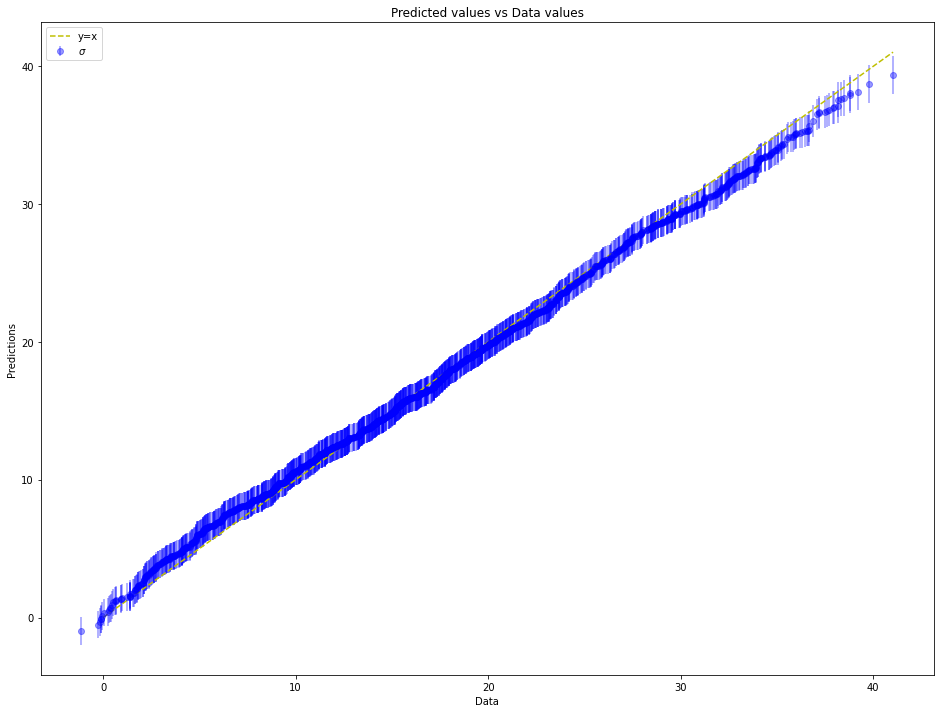

In [13]:
sd = np.sqrt(var)
ydata = Prot
num_gen = len(Mass)
numElems = len(ydata)

idx = np.round(np.linspace(0, len(mu) - 1, numElems)).astype(int)
# Picks equal spaced elements from (longer) prediction array so that its shape of data


y_pred = mean + mu
mu_test = (mean + mu)[idx]
sd_test = sd[idx]
print(mu_test.shape)
print(ydata.shape)
 

vals = np.sort([mu_test, sd_test], axis=1)

# sorts them together :) 

fig = plt.figure(figsize=(16, 12))

plt.plot([0, max(Prot)], [0, max(Prot)], linestyle='--', label='y=x', color='y')
plt.errorbar(np.sort(Prot), vals[0,:], yerr=vals[1,:], fmt='o', label=r'$\sigma$', color='b', alpha=0.4)


plt.xlabel("Data")
plt.ylabel("Predictions")
plt.title("Predicted values vs Data values")
plt.legend()

Fitted the Age vs Prot using a function form of $P \propto aT^b$
Fitting numerically I deteremind $a= 7.01, b = 0.75$
However, fitting by eye and incorpoating prior knowledge, I determined values of $a = 13, b = 0.52$

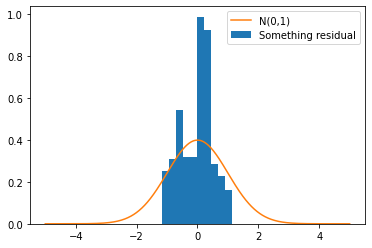

In [14]:
Z = (np.sort(ydata) - vals[0, :])/(vals[1, :])**2



x = np.linspace(-5,5, 1000)
f = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 

plt.hist(Z, density=True, label='Something residual')
 
plt.plot(x,f, label='N(0,1)')
plt.legend()

https://iopscience.iop.org/article/10.1088/0004-637X/695/1/679/pdf
In this article a form is given to determine P from Bv and age that is of a slightly sifferent form to what I am currently using.
$P(t, B-V) = t^{0.52} g(B-V -h)^f$ <br>
where $g=0.77, h=0.4, f = 0.6$. I will now construct another GP using this as the mean function and see how it goes.


In [15]:
g = 0.77
h = 0.4
f = 0.6
X = np.array([Age, Mass,BV]).T 

with pm.Model() as model:
    f_ = pm.Normal('f_', f, f*0.5)

    A_ = pm.Normal('A_', A*g, A*0.3)
   # A_ = A 
    #f_ = f


  
    mean = A_* Age**c_   * Mass **d  * (BV - h)**f_



    l1 = pm.Lognormal('l1', mu=np.log(14.0), sigma=0.11)  # 1
    l2 = pm.Lognormal('l2', mu=np.log(3.6), sigma=0.11)
    l3 = pm.Lognormal('l3', mu=np.log(4), sigma=0.5)

    
    resid = Prot - mean


    sf1 = pm.Lognormal("sf1", mu=np.log(15), sigma=5)
    sf2 = pm.Lognormal("sf2", mu=np.log(40), sigma=15)
    sf3 = pm.Lognormal('sf3', mu=np.log(45), sigma=10)


    K1 = pm.gp.cov.ExpQuad(3, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(3, l2) * sf2**2
    K3 = pm.gp.cov.ExpQuad(3, l3) * sf3**2
    K = K1 * K2 * K3
    
    n = pm.HalfCauchy("n", beta=3)
    n = 1

    gp = pm.gp.Marginal(cov_func=K)
    obs = gp.marginal_likelihood("obs", X=X, y=resid, noise=n)

    mp = pm.find_MAP()





 

In [16]:
print(mp)

{'f_': array(0.64384521), 'A_': array(5.87983252), 'l1_log__': array(2.62714395), 'l2_log__': array(1.26179322), 'l3_log__': array(0.66019421), 'sf1_log__': array(2.12820334), 'sf2_log__': array(2.96247017), 'sf3_log__': array(3.13529276), 'n_log__': array(-3.43569497), 'l1': array(13.83420227), 'l2': array(3.53174903), 'l3': array(1.93516813), 'sf1': array(8.39976176), 'sf2': array(19.34569999), 'sf3': array(22.99536695), 'n': array(0.03220302)}


(1450,)
(1450,)


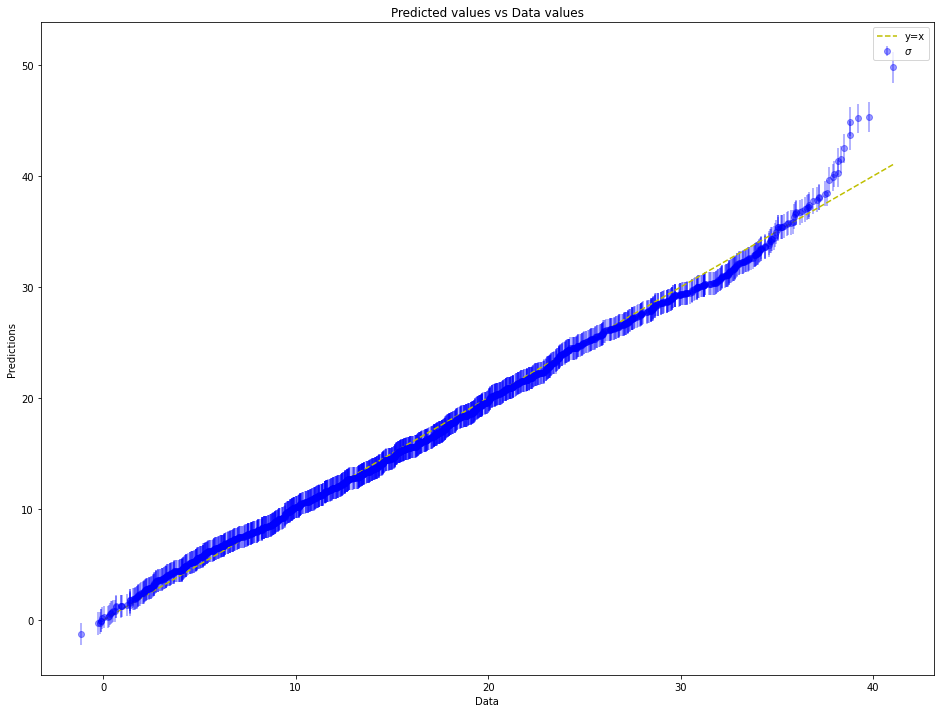

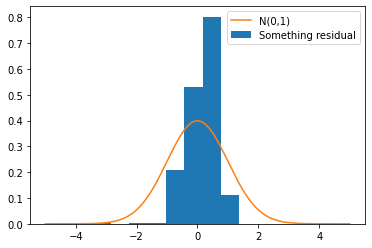

In [17]:
#mean = mean = Age**t_pow * mp['c_'] * (BV - mp['d_'])**mp['f_']
mean = mp['A_'] *Age**c_   * Mass **d  * (BV - h)**mp['f_']

#mean = mp['A_'] * Age**mp['c_']    * Mass **(mp['d_']) * Teff**f
sd = np.sqrt(var)
ydata = Prot
num_gen = len(Mass)
numElems = len(ydata)

idx = np.round(np.linspace(0, len(mu) - 1, numElems)).astype(int)
# Picks equal spaced elements from (longer) prediction array so that its shape of data


y_pred = mean + mu
mu_test = (mean + mu)[idx]
sd_test = sd[idx]
print(mu_test.shape)
print(ydata.shape)
 

vals = np.sort([mu_test, sd_test], axis=1)

# sorts them together :) 

fig = plt.figure(figsize=(16, 12))

plt.plot([0, max(Prot)], [0, max(Prot)], linestyle='--', label='y=x', color='y')
plt.errorbar(np.sort(Prot), vals[0,:], yerr=vals[1,:], fmt='o', label=r'$\sigma$', color='b', alpha=0.4)


plt.xlabel("Data")
plt.ylabel("Predictions")
plt.title("Predicted values vs Data values")
plt.legend()
plt.show()

Z = (np.sort(ydata) - vals[0, :])/(vals[1, :])**2



x = np.linspace(-5,5, 1000)
f = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 

plt.hist(Z, density=True, label='Something residual')
 
plt.plot(x,f, label='N(0,1)')
plt.legend()